# OCR Models Comparison
This notebook compares the performance of several OCR models on the same dataset.

The OCR models used are:

- PaddleOCR
- TrOCR
- DocTr
- Tesseract

The dataset used to refine the models was collected by the researchers from volunteer individuals who sent their prescriptions and volunteer doctors who created synthetic prescriptions.

In [55]:
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

TEST_IMAGES_DIR = r"C:\Users\Shay\Documents\GitHub\ocr-models\data\image_splits\testing_set_full"


In [ ]:
# --- Paths to CSVs ---
CSV_PADDLEOCR = "paddleOCR/test_predictions.csv"
CSV_DOCTR = "my_doctr/DocTR_evaluation.csv"

# --- Load CSVs ---
df1 = pd.read_csv(CSV_PADDLEOCR)
df2 = pd.read_csv(CSV_DOCTR)

# --- Rename prediction columns so they don't clash ---
df1 = df1.rename(columns={"pred": "pred_paddle"})
df2 = df2.rename(columns={"pred": "pred_doc"})

df2 = df2.rename(columns={"gt": "gt_doc"})


# --- Rename cer and wer columns so they don't clash ---
df1 = df1.rename(columns={"cer": "cer_paddle"})
df2 = df2.rename(columns={"cer": "cer_doc"})

df1 = df1.rename(columns={"wer": "wer_paddle"})
df2 = df2.rename(columns={"wer": "wer_doc"})

# --- Merge on 'image' ---
df_merged = pd.merge(df1, df2, on="image", how="inner", suffixes=('_doc', '_paddle'))

# Optional: keep only relevant columns
df_merged = df_merged[["image", "gt_doc", "pred_paddle", "pred_doc", "cer_paddle", "wer_paddle", "cer_doc", "wer_doc"]] \
    if all(col in df_merged.columns for col in ["cer_paddle", "wer_paddle", "cer_doc", "wer_doc"]) else df_merged

# --- Check result ---
print(df_merged.head())
print("Columns:", df_merged.columns.tolist())


         image                                             gt_doc  \
0   data_3.png  Amlodipine 5mg (Provasc) #100 S: 1 tablet once...   
1  data_13.png  1. Vitamin B Complex (PHAREX) #200 170 S: 1 ta...   
2  data_22.png  NAPHAZOLINE #2 PHENIRAMINE MALEATE (VISTALLERG...   
3  data_29.png  Amlodpipine 5mg (Bezam / Provasc) S: 1 tablet ...   
4  data_51.png  TRIAMCINOLONE Acetonide # 4 Sig: Apply lotion ...   

                                         pred_paddle  \
0  ennD- Pnormc) #100 acea8 Ithhel 140 uns mutgon...   
1  O A 170 0y S 3re .8 4 ( W TH mnmoom Buf0 D Du2...   
2  TIT VOCINE HENRANE MAEATE V157mERa gedi &x a d...   
3  cuuls dgune gomn (Bezanil Prorozc) #100 day ta...   
4  TRIAMCINOLONE ACtonide AA Lig Apply lotion to ...   

                                            pred_doc  cer_paddle  wer_paddle  \
0  Rx Ammldodian 5m0 (: Porrvacc #1 1000 S: 1 #al...    0.682927    0.903226   
1  2 c.MAASs #0m RX (A Sx A 10m a 200 170 8: 5 AA...    0.741667    0.978261   
2  - #2 

In [60]:
# Compute summary statistics for each model

summary_rows = []
for model_name, df in dfs.items():
    avg_wer = df['wer'].mean()
    avg_cer = df['cer'].mean()
    exact_match = (df['gt'] == df['pred']).mean()

    summary_rows.append({
        'model': model_name,
        'avg_WER': avg_wer,
        'avg_CER': avg_cer,
        'exact_match_rate': exact_match
    })

summary_df = pd.DataFrame(summary_rows)
summary_df

,model,avg_WER,avg_CER,exact_match_rate
0,test_predictions,0.880328,0.559659,0.0
1,vitstr_base_evaluation,1.232227,0.714416,0.0


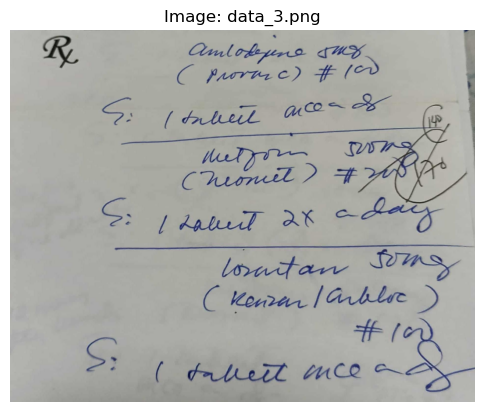

Ground Truth:
Amlodipine 5mg (Provasc) #100 S: 1 tablet once a day Metformin (Neomet) 500mg #200 S: 1 tablet 2x a day #1 Losartan 50mg (Kenzar/Arblok) #100 S: 1 tablet once a day

PaddleOCR Model Prediction:
ennD- Pnormc) #100 acea8 Ithhel 140 uns mutgon (2eo #300 aday 2x Laluil 1 som losuitan Kensan /anblre 1 # mceo iI

DocTR Model Prediction:
Rx Ammldodian 5m0 (: Porrvacc #1 1000 S: 1 #aldcee av0o- 85 Mutfg3m 500Am5 (Nioviec 12 #x 2p 1 S: 1 Raeiee 2m a ddy L0zaatan 50mg ( Revnaaa attaa 10m S 1 ( #otdbetb OUcC Cn S 2 1 -g


In [61]:
# --- Pick a sample (change index to view another row) ---
index = 0
row = df_merged.iloc[index]

image_path = Path(TEST_IMAGES_DIR) / row["image"]
gt_text = row["gt_doc"]
pred_text_paddle = row["pred_paddle"]
pred_text_doc = row["pred_doc"]

# --- Show Image ---
plt.figure(figsize=(6, 6))
plt.imshow(Image.open(image_path))
plt.axis("off")
plt.title(f"Image: {row['image']}")
plt.show()

# --- Print Text ---
print("Ground Truth:")
print(gt_text)

print("\nPaddleOCR Model Prediction:")
print(pred_text_paddle)

print("\nDocTR Model Prediction:")
print(pred_text_doc)